In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

In [151]:
c = 0.5
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
r_m = 1/4
m_electron = 1 * m_unit
m_ion = m_electron / r_m
t_r = 0.4
r_q = 1.0
n_e = 10 #ここは手動で調整すること
B0 = np.sqrt(n_e) / 2.0
n_i = int(n_e / r_q)
T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
T_e = T_i * t_r
q_unit = np.sqrt(epsilon0 * T_e / n_e)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
debye_length = np.sqrt(epsilon0 * T_e / n_e / q_electron**2)
omega_pe = np.sqrt(n_e * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
ion_inertial_length = c / omega_pi
sheat_thickness = 2.0 * ion_inertial_length
v_electron = np.array([0.0, 0.0, c * debye_length / sheat_thickness * np.sqrt(2 / (1.0 + 1/t_r))])
v_ion = -v_electron / t_r
v_thermal_electron = np.sqrt(T_e / m_electron)
v_thermal_ion = np.sqrt(T_i / m_ion)
V_A = B0 / np.sqrt(mu_0 * n_i * m_ion)
beta_e = n_e * T_e / (B0**2 / 2 / mu_0)
beta_i = n_i * T_i / (B0**2 / 2 / mu_0)

dx = 1.0
dy = 1.0
n_x = int(ion_inertial_length * 100)
n_y = int(ion_inertial_length * 30)
x_min = 0.5 * dx
y_min = 0.5 * dy
x_max = n_x * dx - dx
y_max = n_y * dy - dy
x_coordinate = np.arange(0.0, x_max+dx, dx)
y_coordinate = np.arange(0.0, y_max+dy, dy)
dt = 1.0
step = 20000
t_max = step * dt

n_ion = int(n_x * n_i * 2.0 * sheat_thickness)
n_electron = int(n_ion * abs(q_ion / q_electron))
n_ion_background = int(n_x * 0.2 * n_i * (y_max - 2.0 * sheat_thickness))
n_electron_background = int(n_x * 0.2 * n_e * (y_max - 2.0 * sheat_thickness))
buffer_ion = n_i * 10 * n_y
buffer_electron = n_e * 10 * n_y
print(f"total number of particles is {n_ion + n_ion_background + buffer_ion + n_electron + n_electron_background + buffer_electron}.")
print(f"omega_pe = {omega_pe}")
print(f"total time step of 200/Omega_ci = {int(200 / omega_ci)} (10/Omega_ci = {int(10/omega_ci)})")

total number of particles is 2117306.
omega_pe = 0.09449111825230681
total time step of 200/Omega_ci = 16932 (10/Omega_ci = 846)


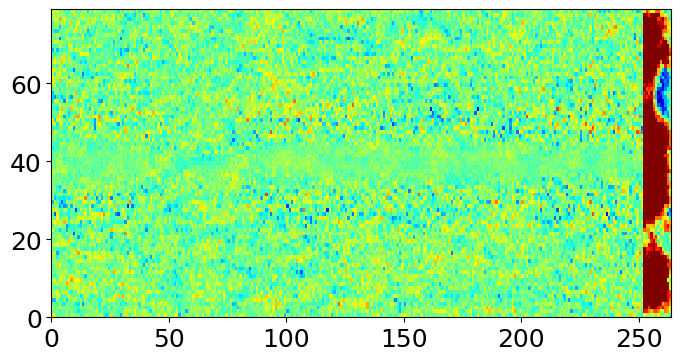

In [156]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

dirname = "mr2008_mr=4_a=2_tr=0.4"
file_num = int(2/omega_ci) * 40
B = np.loadtxt(f'{dirname}/mr2008_B_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
E = np.loadtxt(f'{dirname}/mr2008_E_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
zeroth_moment_electron = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_electron_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
first_moment_electron = np.loadtxt(f'{dirname}/mr2008_first_moment_electron_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
electron_bulk_speed = np.zeros([n_x, n_y, 3])
electron_bulk_speed[:, :, 0] = first_moment_electron[:, :, 0] / (zeroth_moment_electron + 1e-10)
electron_bulk_speed[:, :, 1] = first_moment_electron[:, :, 1] / (zeroth_moment_electron + 1e-10)
electron_bulk_speed[:, :, 2] = first_moment_electron[:, :, 2] / (zeroth_moment_electron + 1e-10)
rate = E[:, :, 2] + electron_bulk_speed[:, :, 0] * B[:, :, 1] - electron_bulk_speed[:, :, 1] * B[:, :, 0]

index = 4
X, Y = np.meshgrid(np.arange(n_x/index), np.arange(n_y/index))
ave_rate = np.zeros([int(n_x/index), int(n_y/index)])
for i in range(int(n_x/index)):
     for j in range(int(n_y/index)):
          ave_rate[i, j] = np.mean(rate[index*i:index*(i+1), index*j:index*(j+1)])

mappable = ax.pcolormesh(X, Y, ave_rate.T/V_A/B0, cmap='jet', vmin=-0.5, vmax=0.5)
#ax.set_xlabel('$x / \lambda_i$', fontsize=20)
#ax.set_ylabel('$y / \lambda_i$', fontsize=20)
#ax.set_xlim(0.0, x_max/ion_inertial_length)
#ax.set_ylim(0.0, y_max/ion_inertial_length)
ax.tick_params(labelsize=18)

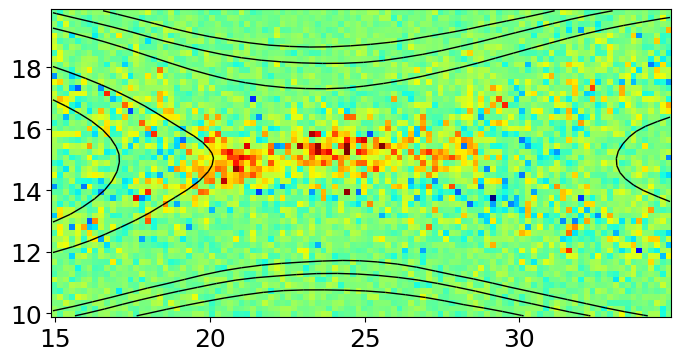

: 

In [158]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

dirname = "mr2008_mr=4_a=2_tr=0.4"
file_num = int(2/omega_ci) * 40
B = np.loadtxt(f'{dirname}/mr2008_B_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
E = np.loadtxt(f'{dirname}/mr2008_E_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
zeroth_moment_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
first_moment_ion = np.loadtxt(f'{dirname}/mr2008_first_moment_ion_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
ion_bulk_speed = np.zeros([n_x, n_y, 3])
ion_bulk_speed[:, :, 0] = first_moment_ion[:, :, 0] / (zeroth_moment_ion + 1e-10)
ion_bulk_speed[:, :, 1] = first_moment_ion[:, :, 1] / (zeroth_moment_ion + 1e-10)
ion_bulk_speed[:, :, 2] = first_moment_ion[:, :, 2] / (zeroth_moment_ion + 1e-10)
zeroth_moment_electron = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_electron_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
first_moment_electron = np.loadtxt(f'{dirname}/mr2008_first_moment_electron_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
electron_bulk_speed = np.zeros([n_x, n_y, 3])
electron_bulk_speed[:, :, 0] = first_moment_electron[:, :, 0] / (zeroth_moment_electron + 1e-10)
electron_bulk_speed[:, :, 1] = first_moment_electron[:, :, 1] / (zeroth_moment_electron + 1e-10)
electron_bulk_speed[:, :, 2] = first_moment_electron[:, :, 2] / (zeroth_moment_electron + 1e-10)
rate = (E[:, :, 0] + electron_bulk_speed[:, :, 1] * B[:, :, 2] - electron_bulk_speed[:, :, 2] * B[:, :, 1]) \
     * (q_ion * ion_bulk_speed[:, :, 0] + q_electron * electron_bulk_speed[:, :, 0]) \
     + (E[:, :, 1] + electron_bulk_speed[:, :, 2] * B[:, :, 0] - electron_bulk_speed[:, :, 0] * B[:, :, 2]) \
     * (q_ion * ion_bulk_speed[:, :, 1] + q_electron * electron_bulk_speed[:, :, 1]) \
     + (E[:, :, 2] + electron_bulk_speed[:, :, 0] * B[:, :, 1] - electron_bulk_speed[:, :, 1] * B[:, :, 0]) \
     * (q_ion * ion_bulk_speed[:, :, 2] + q_electron * electron_bulk_speed[:, :, 2]) \

xmin = int(15 * ion_inertial_length)
xmax = int(35 * ion_inertial_length)
ymin = int(10 * ion_inertial_length)
ymax = int(20 * ion_inertial_length)
start_points = np.array([[15, 15, 15, 16, 18, 16, 18, 20, 34], 
                         [10.1, 12, 13, 10, 10, 19, 19, 19, 14]])
X, Y = np.meshgrid(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)) / ion_inertial_length
ax.streamplot(X, Y, B[xmin:xmax, ymin:ymax, 0].T, B[xmin:xmax, ymin:ymax, 1].T, broken_streamlines=False, 
              start_points=start_points.T, color='k', linewidth=1, arrowsize=0)

ave_rate = np.zeros([int(xmax-xmin), int(ymax-ymin)])
index = 2
for i in range(int((xmax-xmin)/index)):
     for j in range(int((ymax-ymin)/index)):
          ave_rate[index*i:index*(i+1), index*j:index*(j+1)] = np.mean(rate[xmin+index*i:xmin+index*(i+1), ymin+index*j:ymin+index*(j+1)])
mappable = ax.pcolormesh(X, Y, ave_rate.T/V_A/B0/c, cmap='jet', vmin=-0.003, vmax=0.003)
#ax.set_xlabel('$x / \lambda_i$', fontsize=20)
#ax.set_ylabel('$y / \lambda_i$', fontsize=20)
#ax.set_xlim(0.0, x_max/ion_inertial_length)
#ax.set_ylim(0.0, y_max/ion_inertial_length)
ax.tick_params(labelsize=18)

### 磁力線

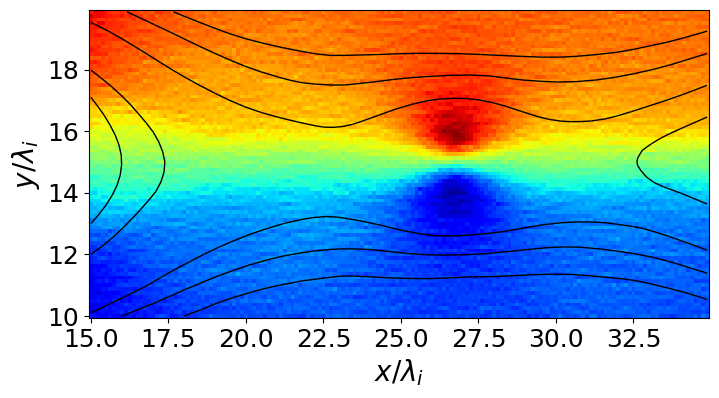

In [132]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

dirname = "mr2008_mr=4_a=2_tr=1"
file_num = int(10/omega_ci) * 10
B = np.loadtxt(f'mr2008_mr=4_a=2_tr=1/mr2008_B_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)

xmin = int(15 * ion_inertial_length)
xmax = int(35 * ion_inertial_length)
ymin = int(10 * ion_inertial_length)
ymax = int(20 * ion_inertial_length)
start_points = np.array([[15, 15, 15, 16, 18, 16, 18, 20, 34], 
                         [10.1, 12, 13, 10, 10, 19, 19, 19, 14]])
X, Y = np.meshgrid(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)) / ion_inertial_length
mappable = ax.pcolormesh(X, Y, B[xmin:xmax, ymin:ymax, 0].T/B0, cmap='jet', vmin=-1.0, vmax=1.0)
ax.streamplot(X, Y, B[xmin:xmax, ymin:ymax, 0].T, B[xmin:xmax, ymin:ymax, 1].T, broken_streamlines=False, 
              start_points=start_points.T, color='k', linewidth=1, arrowsize=0)
ax.set_xlabel('$x / \lambda_i$', fontsize=20)
ax.set_ylabel('$y / \lambda_i$', fontsize=20)
ax.tick_params(labelsize=18)